<a href="https://colab.research.google.com/github/anopsy/Datathon/blob/main/frequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn as sns

In [ ]:
# read file and clean column labels
def read_tidy(path):
  '''
  takes a path to a data file, reads and tidies
  returns data frame with clean labels
  '''
  df = pd.read_csv(path, delimiter=',', parse_dates=['    DATE'])
  df.columns = df.columns.str.strip()
  df['month'] = df['DATE'].dt.month
  df['TX']=df['TX']*0.1
  df.loc[df['TX']<=-50, ['TX']] = np.nan

  return df

In [ ]:
#temp_lisbona = read_tidy('/content/dailyMAXlisbona.txt')
#temp_krakow = read_tidy('/content/dailyMAXlisbona.txt')
temp_berlin = read_tidy('/content/GER_BERLIN.txt')
temp_samara = read_tidy('/content/RUS_SAMARA.txt')
temp_madrid = read_tidy('/content/SPN_MADRID.txt')
temp_poznan = read_tidy('/content/POL_POZNAN.txt')
temp_maastricht = read_tidy('/content/NLD_MAASTRICHT.txt')

In [ ]:
temp_maastricht.describe()

,STAID,SOUID,TX,Q_TX,month
count,41305.0,41305.000000,41305.000000,41305.0,41305.000000
mean,168.0,1949.543784,13.692732,-9.0,6.516136
std,0.0,35629.180151,7.777187,0.0,3.450023
min,168.0,546.000000,-13.200000,-9.0,1.000000
25%,168.0,546.000000,7.900000,-9.0,4.000000
50%,168.0,546.000000,13.800000,-9.0,7.000000
75%,168.0,546.000000,19.500000,-9.0,10.000000
max,168.0,906380.000000,38.200000,-9.0,12.000000


In [ ]:
def avg_period(df):
  '''
  calculates monthly average for the period 1961-1990
  returns df with monthly average
  '''
  period = df[(df['DATE']>='1961-01-01') & (df['DATE']<='1991-12-31')]
  avg = period.groupby('month')['TX'].mean()
  avg = pd.DataFrame(avg)
  avg = avg.reset_index(level = 0)
  return avg

In [ ]:
def merg_avg_split(df):
  '''
  merges the daily max temp with 1961-1990 monthly average
  caclulates the difference
  and returns two df before 1991 and after 1991
  '''
  avg = avg_period(df)
  temp_with_avg = df.merge(avg, how='outer', on='month')
  temp_with_avg['diff'] = temp_with_avg['TX_x'] -temp_with_avg['TX_y']
  before = temp_with_avg[(temp_with_avg['DATE']>='1961-01-01') & (temp_with_avg['DATE']<='1991-12-31')]
  after = temp_with_avg[temp_with_avg['DATE']>'1991-12-31']
  return before, after

In [ ]:
berlin_before, berlin_after = merg_avg_split(temp_berlin)
maastricht_before, maastricht_after = merg_avg_split(temp_maastricht)
poznan_before, poznan_after = merg_avg_split(temp_poznan)
samara_before, samara_after = merg_avg_split(temp_samara)
madrid_before, madrid_after = merg_avg_split(temp_madrid)

In [ ]:
def detect_heatwave(df):
  '''
  detects periods of at least 5 days where
  max temperatures were at least 5 degrees higher than max avg
  '''
  df.reset_index(inplace=True)
  hot_days = pd.DataFrame()
  heatwave = pd.DataFrame()
  for index, row in df.iterrows():
    if (row['diff']>=5) & (row['TX_x']>=25):
      hot_days = pd.concat([hot_days, df.iloc[[index]]], ignore_index=True)
    else:
      if len(hot_days)>=5:
        heatwave = pd.concat([heatwave, hot_days], ignore_index=True)
      hot_days = pd.DataFrame()
  return heatwave

In [ ]:
berlin_heatwave_before = detect_heatwave(berlin_before)
berlin_heatwave_after = detect_heatwave(berlin_after)
maastricht_heatwave_before = detect_heatwave(maastricht_before)
maastricht_heatwave_after = detect_heatwave(maastricht_after)
poznan_heatwave_before = detect_heatwave(poznan_before)
poznan_heatwave_after = detect_heatwave(poznan_after)
samara_heatwave_before = detect_heatwave(samara_before)
samara_heatwave_after = detect_heatwave(samara_after)
madrid_heatwave_before = detect_heatwave(madrid_before)
madrid_heatwave_after = detect_heatwave(madrid_after)

In [ ]:

print(len(berlin_heatwave_before)/len(berlin_before))
print(len(berlin_heatwave_after)/len(berlin_after))

0.015714285714285715
0.02290487739153867


In [ ]:
print(len(maastricht_heatwave_before)/len(maastricht_before))
print(len(maastricht_heatwave_after)/len(maastricht_after))

0.008832361773538244
0.02304426925409339


In [ ]:
print(len(poznan_heatwave_before)/len(poznan_before))
print(len(poznan_heatwave_after)/len(poznan_after))

0.009627274333156686
0.02434097565902434


In [ ]:
print(len(samara_heatwave_before)/len(samara_before))
print(len(samara_heatwave_after)/len(samara_after))

0.02861937991343521
0.04554504728720757


In [ ]:
print(len(madrid_heatwave_before)/len(madrid_before))
print(len(madrid_heatwave_after)/len(madrid_after))

0.02930467986857295
0.04851998779371376


In [ ]:
def show_heatwaves(df):
  before, after = merg_avg_split(df)
  heatwaves_before = detect_heatwave(before)
  heatwaves_after = detect_heatwave(after)
  sns.scatterplot(data=before, x = 'DATE', y='diff')
  sns.scatterplot(data=heatwaves_before, x = 'DATE', y='diff')
  plt.savefig('before')
  plt.clf()
  sns.scatterplot(data=after, x ='DATE', y='diff')
  sns.scatterplot(data=heatwaves_after, x ='DATE', y='diff')
  plt.savefig('after')

In [ ]:
def heatwaves_dates(df):
  before, after = merg_avg_split(df)
  heatwaves_before = detect_heatwave(before)
  heatwaves_after = detect_heatwave(after)
  sns.scatterplot(data=heatwaves_before, x = 'DATE', y='TX_x', hue='diff', legend = False)
  sns.scatterplot(data=heatwaves_after, x ='DATE', y='TX_x', hue='diff')
  plt.legend(loc='upper right')
  plt.savefig('comparison')

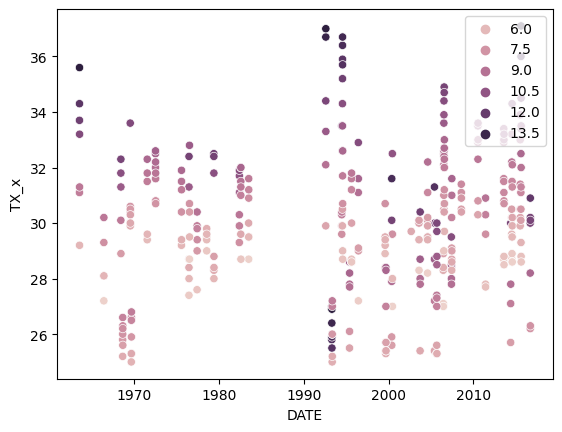

In [ ]:
show_heatwaves(temp_poznan)
plt.clf()
heatwaves_dates(temp_poznan)

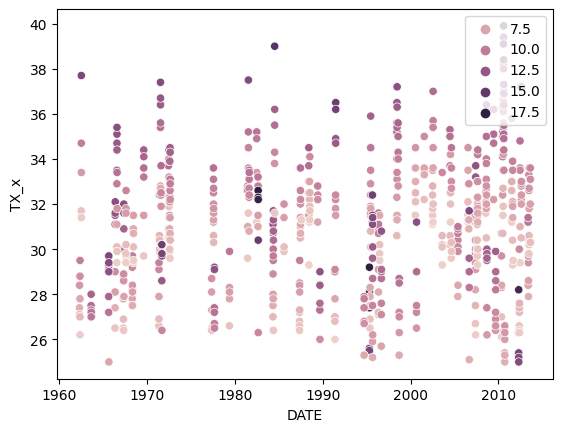

In [ ]:
show_heatwaves(temp_samara)
plt.clf()
heatwaves_dates(temp_samara)

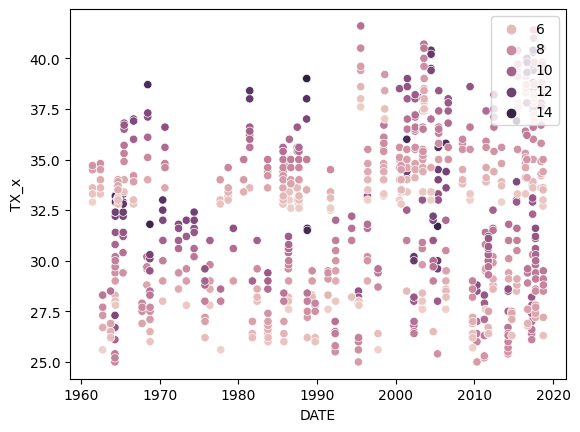

In [ ]:
plt.clf()
show_heatwaves(temp_madrid)
plt.clf()
heatwaves_dates(temp_madrid)

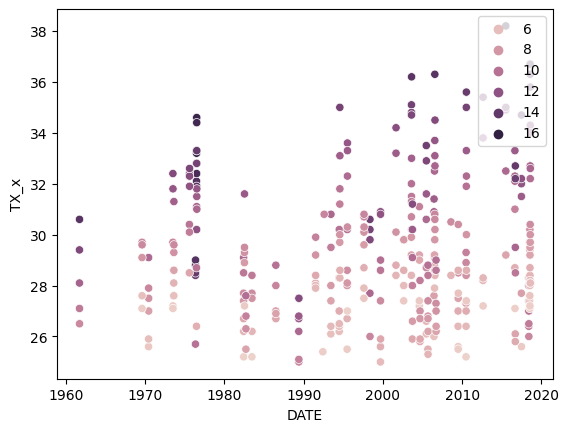

In [ ]:
plt.clf()
show_heatwaves(temp_maastricht)
plt.clf()
heatwaves_dates(temp_maastricht)

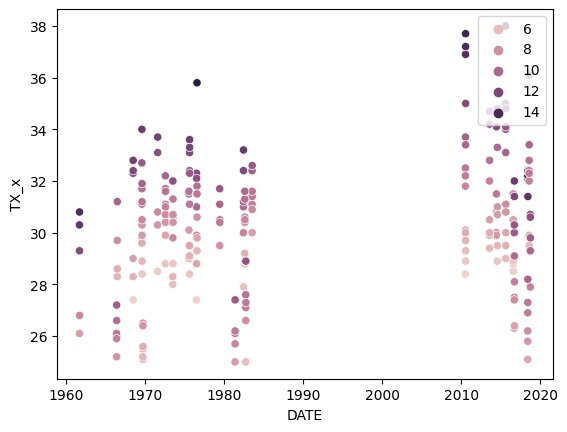

In [ ]:
plt.clf()
show_heatwaves(temp_berlin)
plt.clf()
heatwaves_dates(temp_berlin)

Calculate number of heatwaves per decade
